In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
import seaborn as sns

# Kolmogorov-Arnold Representation Theorem (KAR Theorem)

The **Kolmogorov-Arnold Representation Theorem** is a fundamental result in mathematical approximation theory that states that any multivariate continuous function can be represented as a sum of univariate functions applied to linear combinations of the input variables.

## Formal Statement of the Theorem

Let $$f: [0,1]^n \to \mathbb{R}$$ be any continuous function. Then, there exist continuous univariate functions $$\phi_i$$ such that:

$$
f(x_1, x_2, ..., x_n) = \sum_{i=1}^{2n+1} \phi_i \left(\sum_{j=1}^{n} c_{ij} x_j \right)
$$

where:

- $$c_{ij}$$ are constant coefficients defining a linear transformation of the input variables.
- $$\phi_i$$ are continuous univariate functions.

## Significance of the Theorem

- This theorem, introduced by Andrey Kolmogorov and later refined by Vladimir Arnold, provides a universal representation of high-dimensional functions using only univariate functions.
- It helps overcome the curse of dimensionality, allowing complex multivariate functions to be approximated efficiently.
- It has significant implications for neural networks, as it suggests that a network with a **single hidden layer** using univariate activation functions can approximate any function.

---

# Kolmogorov-Arnold Networks (KAN)

A **Kolmogorov-Arnold Network (KAN)** is a neural network architecture that leverages the KAR theorem to approximate functions using learnable basis functions instead of traditional weighted sum activation layers.

## KAN Architecture

The provided **KAN model** implements a function approximator using **B-Spline basis functions**. Below is an explanation of its key components:

### 1. KANLayer: Basis-Spline Transformation
- Each **KANLayer** applies a basis-spline transformation to the input data.
- The layer defines a set of **knots** that partition the input space into a discrete number of intervals.
- For each input feature, a set of **basis functions** (such as Gaussian-like B-Splines) are computed.
- The basis functions are then weighted using trainable parameters, allowing the network to learn nonlinear feature mappings.

### 2. Forward Pass in KANLayer
- The input features are expanded to match the number of basis functions.
- The distances from the knots are computed.
- A weighted sum of basis functions is applied, transforming the inputs into a higher-dimensional feature space.

### 3. KAN Model Structure
The **KAN model** consists of:
1. **First KAN Layer**: Maps the input features (image pixels in MNIST) to a higher-dimensional feature space using B-Spline basis functions.
2. **Nonlinear Activation (ReLU)**: Introduces nonlinearity to improve expressive power.
3. **Second KAN Layer**: Maps the transformed features to the output space (classification labels).

---

# Mathematical Representation of the KAN Model

Given an input \( x \), the transformation applied by a **KAN layer** can be expressed as:

$$
h_j(x) = \sum_{i=1}^{M} w_{ij} \cdot \phi_i(x) + b_j
$$

where:

- $$ \phi_i(x) $$ are B-Spline basis functions.
- $$ w_{ij} $$ are trainable weights.
- $$ b_j $$ is the bias term.

The final model output is obtained by applying this transformation in a **layer-wise fashion**, similar to a standard neural network but using learnable function approximators instead of linear transformations.

---

# Advantages of Kolmogorov-Arnold Networks (KAN)

1. **Efficient Function Approximation**: KANs leverage the universal representation of the KAR theorem to approximate any function with high accuracy.
2. **Fewer Parameters**: Unlike deep neural networks, KANs do not require multiple hidden layers; instead, they use basis functions to achieve expressivity.
3. **Interpretability**: Since each neuron applies a univariate transformation, KANs are more interpretable compared to black-box deep learning models.
4. **Smoothness & Stability**: The use of B-Spline basis functions ensures that the learned functions are smooth and stable.



In [2]:
# Basis-Spline based Kolmogorov-Arnold Network (KAN) Layer
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features, num_basis=10):
        super(KANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_basis = num_basis

        # Spline coefficients
        self.weights = nn.Parameter(torch.randn(out_features, in_features, num_basis))
        self.bias = nn.Parameter(torch.randn(out_features))

        # B-spline knots
        self.knots = torch.linspace(0, 1, num_basis)

    def forward(self, x):
        # B-spline transformation to each input feature
        x_expanded = x.unsqueeze(-1).expand(-1, -1, self.num_basis)

        # Distance from knot
        knot_distances = torch.abs(x_expanded - self.knots.to(x.device))

        # B-spline basis functions
        basis_values = torch.exp(-knot_distances ** 2)

        # Weighted sum of basis functions
        transformed = torch.einsum('bij, kij -> bk', basis_values, self.weights)

        return transformed + self.bias


class KAN(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=256, output_dim=10, num_basis=10):
        super(KAN, self).__init__()
        self.kan1 = KANLayer(input_dim, hidden_dim, num_basis)
        self.kan2 = KANLayer(hidden_dim, output_dim, num_basis)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.kan1(x)
        x = F.relu(x)
        x = self.kan2(x)
        return x

In [3]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The model achieves a test accuracy of 80.74%, which is consistent with the final validation accuracy, indicating that the model generalizes well to unseen data without significant overfitting.









In [ ]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0
best_model_path = './best_model.pth'

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    #Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Train Loss: {total_loss / len(train_loader):.4f}, Val Acc: {val_acc:.2f}%")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch+1} with val acc {best_val_acc:.2f}%")

# Best model for testing
model.load_state_dict(torch.load(best_model_path))
model.eval()

test_correct, test_total = 0, 0
test_labels, test_preds, test_probs = [], [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
        test_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities for ROC

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")




Epoch 1, Train Loss: 5.9030, Val Acc: 62.90%
Best model saved at epoch 1 with val acc 62.90%
Epoch 2, Train Loss: 1.9013, Val Acc: 67.86%
Best model saved at epoch 2 with val acc 67.86%
Epoch 3, Train Loss: 1.3803, Val Acc: 69.42%
Best model saved at epoch 3 with val acc 69.42%
Epoch 4, Train Loss: 1.1363, Val Acc: 71.88%
Best model saved at epoch 4 with val acc 71.88%
Epoch 5, Train Loss: 0.9716, Val Acc: 74.13%
Best model saved at epoch 5 with val acc 74.13%
Epoch 6, Train Loss: 0.8764, Val Acc: 76.91%
Best model saved at epoch 6 with val acc 76.91%
Epoch 7, Train Loss: 0.8003, Val Acc: 78.95%
Best model saved at epoch 7 with val acc 78.95%
Epoch 8, Train Loss: 0.7393, Val Acc: 78.78%
Epoch 9, Train Loss: 0.6998, Val Acc: 78.16%
Epoch 10, Train Loss: 0.6779, Val Acc: 80.89%
Best model saved at epoch 10 with val acc 80.89%


<ipython-input-4-80b3b365ca74>:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Accuracy: 80.74%


The AUC (Area Under the Curve) of 0.99 indicates that the model has good discriminative ability, effectively distinguishing between classes with a very high true positive rate and a low false positive rate.

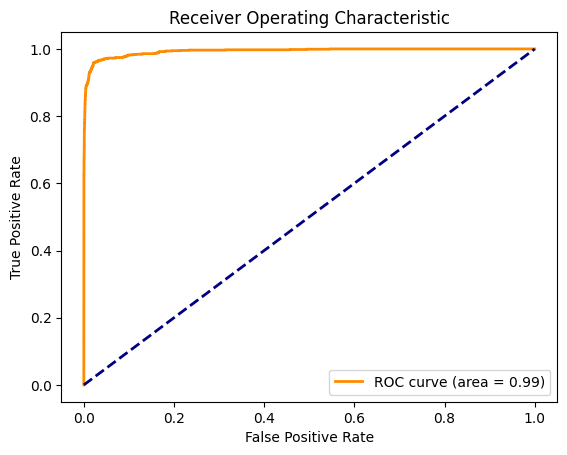

In [ ]:
fpr, tpr, _ = roc_curve(test_labels, test_probs, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



From the confusion matrix, it can be seen that the classification model performs well across most digits, but certain classes (e.g. 4,9) exhibit more misclassifications, suggesting potential areas for improvement.

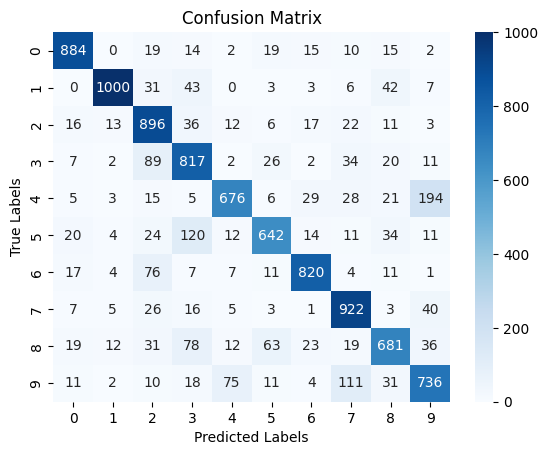

In [ ]:
conf_matrix = confusion_matrix(test_labels, test_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()